# Circular track runs using von Mises (~ circular Gaussian) place fields

In [1]:
#import networkx as nx
#import pyximport; pyximport.install()
import sys
sys.path.insert(0, './helpers')

import numpy as np
import circstats as circ # for von Mises pdf
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Experimental parameters

In [2]:
NumNeurons = 100;
DataFilename = "vonMisesData_100neurons.p"

NeuronParameters = {
    # Maruer et al (Hippocampus, 2006) suggests place field widths of between 10 and 100 cm
"pfminsize" : 25,   # minimum place field width [cm]
"pfmaxsize" : 25,   # maximum place field width [cm]
"pcminrate" : 5,    # minimum peak firing rate [Hz] typical average is about 10 Hz
"pcmaxrate" : 15,   # maximum peak firing rate [Hz]
"minbkgrate" : 0.5, # minimum background firing rate [Hz] (non-place cells)
"maxbkgrate" : 2    # maximum background firing rate [Hz] (non-place cells)
};

WorldParameters = {
"NEnv" : 5,           # number of environments
"alpha" : 0.5,        # probability that a recorded cells is active in env
"TrackLength" : 380   # track circumference in cm - matches Maurer 2006
};

# Generate Neurons

In [3]:
Neurons = []; # Neurons will be a list of parameters per neuron
def GenerateNeuron(WorldParameters, NeuronParameters) :
    NEnv = WorldParameters["NEnv"];
    HasField = np.random.binomial(1,WorldParameters["alpha"],NEnv).astype(bool)
    Neuron = { "NEnv" : NEnv,
        "PFHasField" : HasField,
        "PFCenter": np.where(HasField, np.random.uniform(0, WorldParameters["TrackLength"], NEnv),
                             np.ones(NEnv) * WorldParameters["TrackLength"]),
        "PFRate" : np.where(HasField, np.random.uniform(NeuronParameters["pcminrate"], NeuronParameters["pcmaxrate"], NEnv), 
                            np.zeros(NEnv)), 
        "PFWidth" : np.random.uniform(NeuronParameters["pfminsize"], NeuronParameters["pfmaxsize"], NEnv),
        "BackgroundRate" : np.random.uniform(NeuronParameters["minbkgrate"], NeuronParameters["maxbkgrate"], NEnv)}
    return Neuron
for i in range(0,NumNeurons) :
    Neurons.append(GenerateNeuron(WorldParameters,NeuronParameters))
    
Neurons.sort(key=lambda neuron: neuron['PFCenter'][0]) # sort by PF locations in environment 1

In [4]:
Neurons[0]

{'BackgroundRate': array([ 1.23377051,  1.87817152,  1.80211204,  1.38677478,  0.90936203]),
 'NEnv': 5,
 'PFCenter': array([   7.19300589,  282.56323799,  380.        ,  380.        ,  380.        ]),
 'PFHasField': array([ True,  True, False, False, False], dtype=bool),
 'PFRate': array([ 11.27852348,  13.81145225,   0.        ,   0.        ,   0.        ]),
 'PFWidth': array([ 25.,  25.,  25.,  25.,  25.])}

In [5]:
np.random.binomial(1,0.1,10).astype(bool)

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [6]:
# Modify for a circular track. Assume TrackDiameter is the same as TrackLength
WorldParameters["TrackCircumference"] = WorldParameters["TrackLength"]
for n in Neurons :
    n["PFTheta"] = 2 * np.pi * n["PFCenter"] / WorldParameters["TrackCircumference"]; # Angle of PF
    # If width is defined as distance between 10% level, for a Gaussian field, this is about 2.5 std devs.
    std_dev = n["PFWidth"] / 2.5
    # The von Mises kappa is one over the variance in limit of small kappa, and is expressed in radians**2
    n["PFKappa"] = 1 / ((2 * np.pi * std_dev/WorldParameters["TrackCircumference"])**2);
    n["PFRateScaling"] = n["PFRate"] * np.i0(n["PFKappa"]) * 2 * np.pi / np.exp(n["PFKappa"])
Neurons[0]

{'BackgroundRate': array([ 1.23377051,  1.87817152,  1.80211204,  1.38677478,  0.90936203]),
 'NEnv': 5,
 'PFCenter': array([   7.19300589,  282.56323799,  380.        ,  380.        ,  380.        ]),
 'PFHasField': array([ True,  True, False, False, False], dtype=bool),
 'PFKappa': array([ 36.57694729,  36.57694729,  36.57694729,  36.57694729,  36.57694729]),
 'PFRate': array([ 11.27852348,  13.81145225,   0.        ,   0.        ,   0.        ]),
 'PFRateScaling': array([ 4.6907634 ,  5.74421419,  0.        ,  0.        ,  0.        ]),
 'PFTheta': array([ 0.11893418,  4.67209786,  6.28318531,  6.28318531,  6.28318531]),
 'PFWidth': array([ 25.,  25.,  25.,  25.,  25.])}

In [7]:
# Von Mises Place Field Rate Function
def PlaceFieldRate(phi, Env, NeuronParams) : # phi is current track position in radians
    y = circ.vmpdf(phi, NeuronParams["PFTheta"][Env], NeuronParams["PFKappa"][Env])
    return y * NeuronParams["PFRateScaling"][Env] + NeuronParams["BackgroundRate"][Env]

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


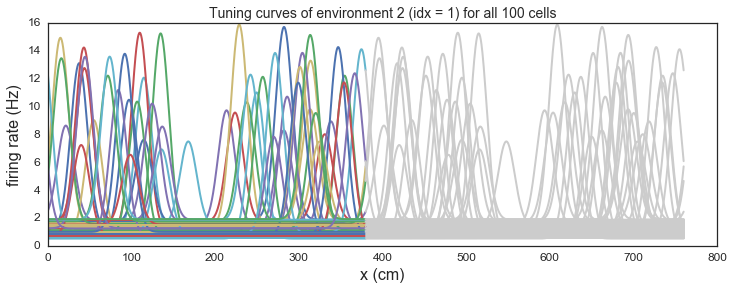

In [8]:

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

f, (ax1) = plt.subplots(1,1)

Phi = np.linspace(0,2*np.pi,1000);
ee = 1; # select environment
for n in Neurons :
    ax1.plot(Phi/(2*np.pi)*WorldParameters["TrackCircumference"],PlaceFieldRate(Phi,ee,n))
    ax1.plot((Phi+ 2*np.pi)/(2*np.pi)*WorldParameters["TrackCircumference"], PlaceFieldRate(Phi,ee,n), color=[0.8,0.8,0.8])

ax1.set_xlabel('x (cm)')
ax1.set_ylabel('firing rate (Hz)')
ax1.set_title('Tuning curves of environment {0} (idx = {1}) for all {2} cells'.format(ee+1,ee,NumNeurons),fontsize=14)



# Generate Neural Activity

In [9]:
# Synthesize neural activity using rat running at constant (circular) rate
RatLinearSpeed = 20; # 20 cm/s
RatRadialSpeed = 2 * np.pi * RatLinearSpeed / WorldParameters["TrackCircumference"]

TrajLength = 10; # seconds; corresponds to 30% of the track. 
    
# We'll generate several trajectories for each environment
NumTrajectories = 1000;
TrajStartPos = np.random.uniform(0, 2*np.pi, (NumTrajectories, WorldParameters["NEnv"]))

In [10]:
from GenerateInhomogeneousPlaceCellSpikes import GenerateSpikes
import time

# Initialize SpikeRaster as a list of lists of lists, where the first (outer) dimension
#  is environment, the next dimension is trajectory, and the final dimension is neuron.
#  Then, for each neuron, there is a np.ndarray which contains the spike times for that
#  neuron on that trajectory of that environment.
SpikeRasters = [[[[] for _ in range(len(Neurons))] for _ in range(NumTrajectories)] for _ in range(WorldParameters["NEnv"])]
t0 = time.time();
for ee in range(WorldParameters["NEnv"]) :
    for k in range(NumTrajectories) :
        for (i,n) in enumerate(Neurons) :
            posFun = lambda t : np.mod(RatRadialSpeed * t + TrajStartPos[k][ee], 2 * np.pi)
            SpikeRasters[ee][k][i] = GenerateSpikes(lambda x,t : PlaceFieldRate(x, ee, n), n["PFRate"][ee], 
                                                    posFun, TrajLength);

t1 = time.time();
print(t1-t0)

12.27111005783081


In [11]:
import pickle
with open(DataFilename, "wb") as output_file:
    pickle.dump(
        [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters],
        output_file)